In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import auc, accuracy_score, roc_curve, precision_score, recall_score, f1_score
from sklearn import svm
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import os

In [2]:
# List of all the lineages we will be making dataframes for - some of the DFs don't have a col named depmapid but have depmapids, will require some cleaning
lineages = ["kidney", "breast", "blood", "liver", "urinary_tract", "colorectal", "ovary", "pancreas"]
lineage_df_dict = {}

In [3]:
# List of all the feature dataframes we are going to read into the lineage dataframes
features = ["effect", "dependency", "expression", "gene_cn"]
feature_df_dict = {}

In [4]:
sample_info_df = pd.read_csv('data/sample_info.csv')

In [5]:
folder_path = "data/"

for file_name in os.listdir(folder_path):
    for feature in features:
        if file_name.endswith('.csv') and feature in file_name:
            file_path = os.path.join(folder_path, file_name)
            feature_df_dict[feature] = pd.read_csv(file_path)
            feature_df_dict[feature].columns = [column.split(' ')[0] for column in feature_df_dict[feature].columns]
            feature_df_dict[feature].rename(columns={feature_df_dict[feature].columns[0]: "DepMap_ID"}, inplace=True)
            feature_df_dict[feature] = pd.merge(feature_df_dict[feature], sample_info_df[['DepMap_ID', 'lineage']], on='DepMap_ID', how='left')
            feature_df_dict[feature].drop("DepMap_ID", axis=1, inplace=True)
            feature_df_dict[feature] = feature_df_dict[feature].pivot_table(index='lineage', aggfunc='mean')

In [6]:
for feature in features:
    for lineage in lineages:
        temp_df = feature_df_dict[feature].loc[feature_df_dict[feature].index == lineage].transpose()
        temp_df.index.name = 'gene'
        if lineage in lineage_df_dict:
            temp_df.rename(columns={lineage : feature}, inplace=True)
            lineage_df_dict[lineage] = pd.merge(lineage_df_dict[lineage], temp_df, on="gene", how="outer").dropna()
        else:
            lineage_df_dict[lineage] = pd.DataFrame({feature: temp_df[lineage]}, index=temp_df.index)
            lineage_df_dict[lineage].index.name = 'gene'
            lineage_df_dict[lineage].reset_index(inplace=True)

In [7]:
lineage_df_dict['colorectal']

,gene,effect,dependency,expression,gene_cn
0,A1BG,-0.015041,0.043599,0.590738,1.002046
1,A1CF,-0.068805,0.083945,1.262503,1.031954
2,A2M,0.001877,0.035082,0.285868,1.075952
3,A2ML1,0.034582,0.030788,0.309722,1.075789
4,A3GALT2,-0.046617,0.062978,0.009425,0.912126
...,...,...,...,...,...
17280,ZYG11A,-0.020647,0.046334,0.178135,0.920793
17281,ZYG11B,-0.094004,0.087456,2.296709,0.920752
17282,ZYX,-0.015553,0.045229,6.060374,1.142463
17283,ZZEF1,-0.065964,0.070773,3.277261,0.914023


In [8]:
training_dfs = {}
training_lineages = {"kidney" : "kidney", 
                     "breast" : "breast", 
                     "leukemia" : "blood", 
                     "liver" : "liver", 
                     "bladder" : "urinary_tract",
                     "colon" : "colorectal", 
                     "ovarian" : "ovary", 
                     "pancreatic" : "pancreas"}
for k, v in training_lineages.items():
    df = pd.read_csv(f"training_sets_genes/{k}_training_genes_set.csv")
    df = df.merge(lineage_df_dict[v], on="gene", how='left').fillna(0)
    lineage_df_dict[v] = pd.merge(lineage_df_dict[v], df, indicator=True, how='left', on=list(lineage_df_dict[v].columns)).query('_merge == "left_only"').drop('_merge', axis=1)
    lineage_df_dict[v].drop(columns=['label'], inplace=True)
    df.set_index('gene', inplace=True)
    lineage_df_dict[v].set_index('gene', inplace=True)
    training_dfs[k] = df

In [9]:
rev_training_lineages = {value: key for key, value in training_lineages.items()}

## Principal Component Analysis (PCA)

## Random Forest

In [10]:
rf_by_lineage = {}

param_grid = {
    'max_depth' : [4, 5, 6],
    'n_estimators': [250, 375, 500],
    'max_features': ['sqrt', 'log2', 0.3]}

rf = RandomForestClassifier()

skf = StratifiedKFold(n_splits=5,shuffle=True)

pred_labels = {}

# Run on train data
for k, v in training_dfs.items():
    X = training_dfs[k].drop(columns=['label'])
    y= training_dfs[k]['label']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    grid_search_cv = GridSearchCV(estimator=rf, param_grid=param_grid, cv=skf)

    model = grid_search_cv.fit(X_train, y_train)

    y_pred = model.best_estimator_.predict(X_test)
    y_pred_rt = model.best_estimator_.predict_proba(X_test)[:, 1]

    accuracy = str(accuracy_score(y_test, y_pred))

    rf_by_lineage[k] = (accuracy, y_pred, y_pred_rt, model.best_estimator_)

In [15]:
# Predict on Unlabelled Data
rf_predictions = {}
for k, v in lineage_df_dict.items():
    rev_k = rev_training_lineages[k]
    best_rf = rf_by_lineage[rev_k][-1]
    pred_labels[rev_k] = best_rf.predict(lineage_df_dict[k])
    rf_predictions[k] = pd.DataFrame({'gene': v.index, 'prediction': pred_labels[rev_k]})

## Artificial Neural Network

In [ ]:
feature_columns = [ 'effect', 'dependency', 'expression', 'gene_cn']
target_column = 'label'

scaler_df = dict()

# Function to preprocess a dataframe
def preprocess_df(key, df):
    # Extract features and target
    X = df[feature_columns].values
    y = df[target_column].values

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Feature scaling (standardization)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    scaler_df[key] = scaler

    return X_train_scaled, X_test_scaled, y_train, y_test

mlp_classifier_df = dict()

# Function to train and evaluate ANN for a given dataframe
def train_and_evaluate_ann(key,df):
    # Preprocess the dataframe
    X_train, X_test, y_train, y_test = preprocess_df(key,df)

    # Create an Artificial Neural Network classifier
    mlp_classifier = MLPClassifier(hidden_layer_sizes=(10, 10), max_iter=1000, random_state=42)

    # Train the classifier
    mlp_classifier.fit(X_train, y_train)

    # Predictions
    y_pred = mlp_classifier.predict(X_test)

    mlp_classifier_df[key] = mlp_classifier

    # Evaluate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy:", accuracy)

# Loop through each dataframe in the training_dfs dictionary and train/evaluate the ANN
for key, df in training_dfs.items():
    print("Training and evaluating ANN for", key)
    train_and_evaluate_ann(key, df)

# Swap keys and values
swapped_lineages = {value: key for key, value in training_lineages.items()}

ann_prediction = dict()

for key, df in lineage_df_dict.items():
    scaler = scaler_df[swapped_lineages[key]]
    genes = df['gene']
    X = df[feature_columns].values
    X_new_scaled = scaler.transform(X)
    
    # Use the trained ANN model to make predictions on the new data
    y_new_pred = mlp_classifier_df[swapped_lineages[key]].predict(X_new_scaled)

    ann_prediction[key] = pd.DataFrame({'gene': genes, 'prediction': y_new_pred})

ann_prediction


Training and evaluating ANN for kidney
Accuracy: 0.8666666666666667
Training and evaluating ANN for breast
Accuracy: 0.90625
Training and evaluating ANN for leukemia
Accuracy: 0.9183266932270916
Training and evaluating ANN for liver
Accuracy: 0.9117647058823529
Training and evaluating ANN for bladder
Accuracy: 0.8901098901098901
Training and evaluating ANN for colon
Accuracy: 0.8907103825136612
Training and evaluating ANN for ovarian
Accuracy: 0.9126984126984127
Training and evaluating ANN for pancreatic
Accuracy: 0.9256198347107438


{'kidney':           gene prediction
 0         A1BG   negative
 1         A1CF   negative
 2          A2M   negative
 3        A2ML1   negative
 4      A3GALT2   negative
 ...        ...        ...
 17071   ZYG11A   negative
 17072   ZYG11B   negative
 17073      ZYX   negative
 17074    ZZEF1   negative
 17075     ZZZ3   negative
 
 [17076 rows x 2 columns],
 'breast':           gene prediction
 0          A2M   negative
 1        A2ML1   negative
 2      A3GALT2   negative
 3       A4GALT   negative
 4        A4GNT   negative
 ...        ...        ...
 16367   ZYG11A   negative
 16368   ZYG11B   negative
 16369      ZYX   negative
 16370    ZZEF1   negative
 16371     ZZZ3   negative
 
 [16372 rows x 2 columns],
 'blood':           gene prediction
 0         A1CF   negative
 1          A2M   negative
 2        A2ML1   negative
 3      A3GALT2   negative
 4       A4GALT   negative
 ...        ...        ...
 14865     ZXDC   negative
 14866   ZYG11A   negative
 14867   ZYG11B   nega

## Support Vector Machine (SVM)

## Logistic Regression

In [ ]:
def trainLRmodel(X, Y):
    # Get the training and test data
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3)

    # Fit the model
    model = LogisticRegression().fit(X_train, y_train)

    y_pred = model.predict(X_test)
    y_pred_rt = model.predict_proba(X_test)[:, 1]

    accuracy = str(accuracy_score(y_test, y_pred))
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_rt, pos_label=1)
    auc_value = str(auc(fpr, tpr))
    precision = str(precision_score(y_test, y_pred, pos_label='positive'))
    recall = str(recall_score(y_test, y_pred, pos_label='positive'))
    f1score = str(f1_score(y_test, y_pred, average="weighted"))

    # print(f"Lineage: {lineage}\n\n")
    # print(f"Accuracy: {accuracy}\n\n")
    # print(f"Y Test: {y_test}\n\n")
    # print(f"Y Pred: {y_pred}\n\n")
    # print(f"Y Pred RT: {y_pred_rt}\n\n")
    # print(f"Accuracy: {accuracy}\n\n")
    # print(f"AUC: {auc_value}\n\n")
    # print(f"Precision: {precision}\n\n")
    # print(f"Recall: {recall}\n\n")
    # print(f"F1 Score: {f1score}\n\n")

    return [accuracy, y_test, y_pred, y_pred_rt, model, auc_value, precision, recall, f1score]

/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.11/s

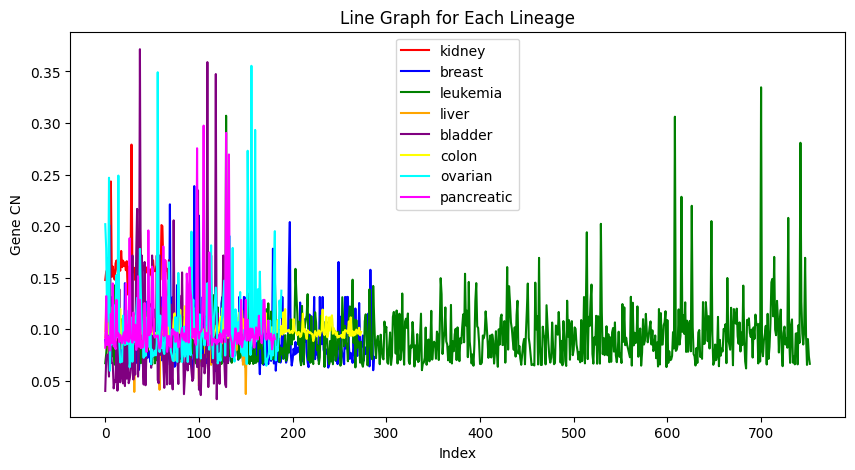

In [ ]:
fig = plt.figure(figsize=(10, 5))
for i in range(len(training_dfs)):
    lineage = list(training_dfs.keys())[i]
    X = training_dfs[lineage].drop(['label'], axis=1)
    Y = training_dfs[lineage]['label']
    accuracy, y_test, y_pred, y_pred_rt, model, auc_value, precision, recall, f1score  = trainLRmodel(X, Y)
    rounded_accuracy = round(float(accuracy), 3)
    # Assuming you have a dictionary 'lineage_df_dict' containing lineages as keys and dataframes as values

    # Create a list of colors for each lineage
    colors = ['red', 'blue', 'green', 'orange', 'purple', 'yellow', 'cyan', 'magenta']

    # Plot a line graph for each lineage
    plt.plot(y_pred_rt, color=colors[i], label=lineage)

# Set the x-axis label
plt.xlabel('Index')

# Set the y-axis label
plt.ylabel('Gene CN')

# Set the title of the graph
plt.title('Line Graph for Each Lineage')

# Add a legend
plt.legend()

# Show the plot
plt.show()

In [ ]:
print(accuracy)

0.9340659340659341
